In [14]:
!pip install --upgrade tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_hub
    Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 3.15.0 requires tensorflow-hub<0.13,>=0.7.0, but you have tensorflow-hub 0.13.0 which is incompatible.


In [15]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import PIL
from tensorflow.keras import Model
import tensorflow_hub as hub

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
    
tf.test.is_gpu_available()

Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU


True

In [3]:
vgg = tf.keras.applications.VGG19(include_top = True, weights = 'imagenet')

574710816/574710816 [==============================] - 5s 0us/step


In [4]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis = 0)
    input_shape = tf.shape(input_tensor)
    ij = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return gram_matrix / ij

In [6]:
def load_vgg():
    vgg = tf.keras.applications.VGG19(include_top = True, weights = 'imagenet')
    vgg.trainable = False
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_output = vgg.get_layer(content_layers[0]).output
    style_output = [vgg.get_layer(i).output for i in style_layers]
    gram_style_output = [gram_matrix(i) for i in style_output]
    
    model = Model([vgg.input], [content_output, gram_style_output])
    return model

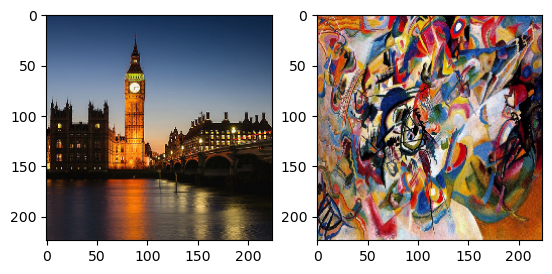

In [7]:
content_image = cv2.resize(cv2.imread('Content Images/download.png'), (224, 224))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('Style Images/Vassily_Kandinsky,_1913_-_Composition_7.jpg'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
opt = tf.optimizers.Adam(learning_rate = 1e-2)

In [9]:
def loss_object(style_output, content_outputs, style_target, content_target):
    style_weight = 15
    content_weight = 2e-5
    content_loss = tf.reduce_mean((content_outputs - content_target) ** 2)
    style_loss = tf.add_n([tf.reduce_mean((output_ - target_) ** 2) for output_, target_ in zip(style_output, style_target)])
    total_loss = (content_weight * content_loss) + (style_weight * style_loss)
    return total_loss

In [10]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_image * 255]))[0]
style_target = vgg_model(np.array([style_image * 255]))[1]

In [11]:
def train_step(image, epoch):
    with tf.GradientTape() as tape:
        output = vgg_model(image * 255)
        loss = loss_object(output[1], output[0], style_target, content_target)
    gradient = tape.gradient(loss, image)
    opt.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0))
    if epoch % 100 == 0:
        tf.print(f"Loss = {loss}")

In [12]:
epochs = 1000
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(epochs):
    train_step(image, i)

Loss = 24143179284480.0
Loss = 153628033024.0
Loss = 73199001600.0
Loss = 50574331904.0
Loss = 39936757760.0
Loss = 33623056384.0
Loss = 29356271616.0
Loss = 26298337280.0
Loss = 24025831424.0
Loss = 22248980480.0


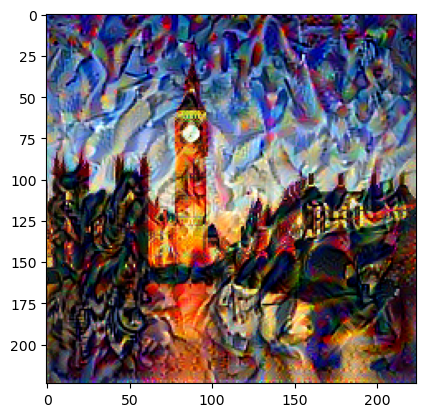

In [13]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()

# Using a Pretrained Model

In [16]:
import tensorflow_hub as hub

In [17]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [18]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [19]:
content_image = load_image('Content Images/download.png')
style_image = load_image('Style Images/Vassily_Kandinsky_1913_-_Composition_7.jpg')

In [20]:
content_image.shape

TensorShape([1, 512, 512, 3])

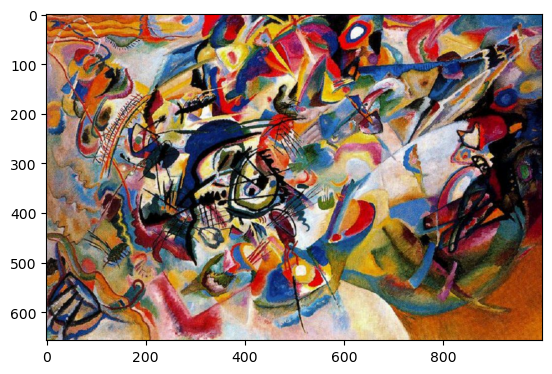

In [22]:
plt.imshow(np.squeeze(style_image))

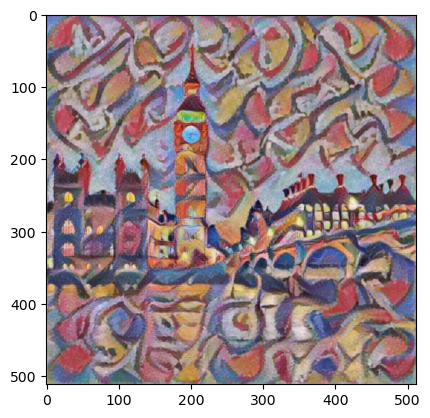

In [25]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]
plt.imshow(np.squeeze(stylized_image))